# This is a sample Jupyter Notebook

Below is an example of a code cell. 
Put your cursor into the cell and press Shift+Enter to execute it and select the next one, or click 'Run Cell' button.

Press Double Shift to search everywhere for classes, files, tool windows, actions, and settings.

To learn more about Jupyter Notebooks in PyCharm, see [help](https://www.jetbrains.com/help/pycharm/ipython-notebook-support.html).
For an overview of PyCharm, go to Help -> Learn IDE features or refer to [our documentation](https://www.jetbrains.com/help/pycharm/getting-started.html).

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.optim as optim

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [5]:
mnist_root = r"C:\Users\User\PycharmProjects\TPNS4\data"  # путь к уже скачанному датасету

batch_size = 64
epochs = 10
learning_rate = 0.001

transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = datasets.MNIST(
    root=mnist_root,
    train=True,
    download=False,
    transform=transform
)

test_dataset = datasets.MNIST(
    root=mnist_root,
    train=False,
    download=False,
    transform=transform
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [6]:
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)  # (1 канал, 6 фильтров, 5x5)
        self.pool = nn.AvgPool2d(2, stride=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)  # выход после conv2+pool
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)  # 10 классов для MNIST

    def forward(self, x):
        x = F.tanh(self.conv1(x))
        x = self.pool(x)
        x = F.tanh(self.conv2(x))
        x = self.pool(x)
        x = x.view(-1, 16 * 4 * 4)  # flatten
        x = F.tanh(self.fc1(x))
        x = F.tanh(self.fc2(x))
        x = self.fc3(x)
        return x


In [7]:
model = LeNet5().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [8]:
train_losses = []
train_accuracies = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct / total

    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    print(f"Epoch [{epoch + 1}/{epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc * 100:.2f}%")

Epoch [1/10], Loss: 0.3224, Accuracy: 90.50%
Epoch [2/10], Loss: 0.1016, Accuracy: 96.94%
Epoch [3/10], Loss: 0.0684, Accuracy: 97.87%
Epoch [4/10], Loss: 0.0527, Accuracy: 98.41%
Epoch [5/10], Loss: 0.0428, Accuracy: 98.66%
Epoch [6/10], Loss: 0.0357, Accuracy: 98.91%
Epoch [7/10], Loss: 0.0297, Accuracy: 99.05%
Epoch [8/10], Loss: 0.0247, Accuracy: 99.20%
Epoch [9/10], Loss: 0.0215, Accuracy: 99.30%
Epoch [10/10], Loss: 0.0195, Accuracy: 99.36%


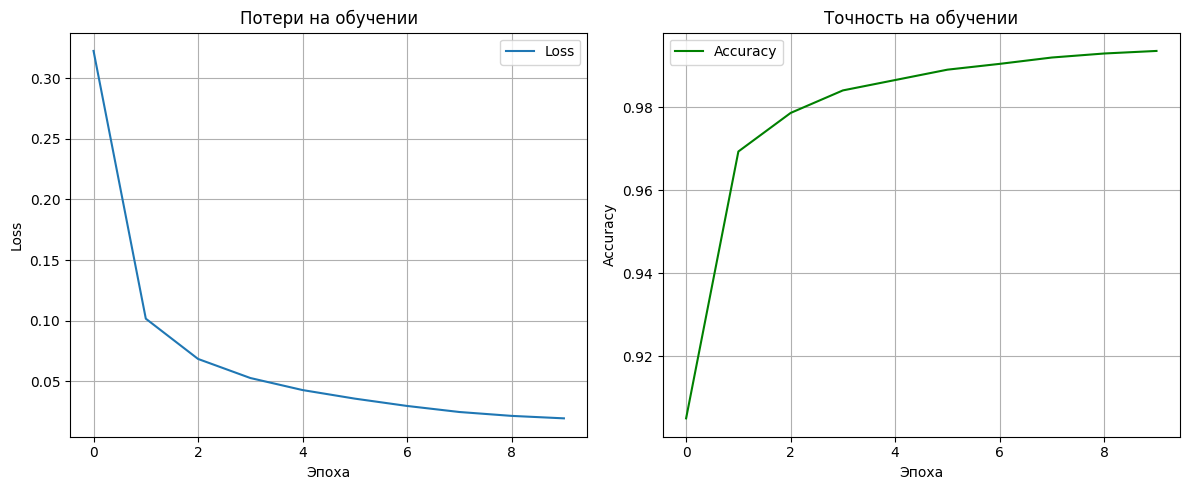

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Loss")
plt.title("Потери на обучении")
plt.xlabel("Эпоха")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Accuracy", color='green')
plt.title("Точность на обучении")
plt.xlabel("Эпоха")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

Точность на тестовых данных: 98.68%


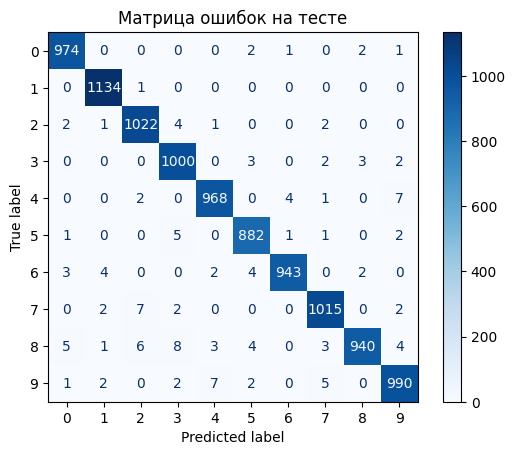

In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

model.eval()
all_preds = []
all_labels = []

correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = 100 * correct / total
print(f'Точность на тестовых данных: {accuracy:.2f}%')

# Матрица ошибок
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(10))
disp.plot(cmap='Blues')
plt.title("Матрица ошибок на тесте")
plt.show()